In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
import GCRCatalogs
try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm



/pbs/home/c/ccombet/.conda/envs/mydesc/lib/python3.7/site-packages/GCRCatalogs/register.py:33: UserWarning: Site determined from env variable DESC_GCR_SITE
  warnings.warn('Site determined from env variable {}'.format(_DESC_SITE_ENV))


Check what version we're using

In [2]:
clmm.__version__

'0.3.0'

### 1. Prepare a CLMM GalaxyCluster object from cosmoDC2 

#### Read in the extragalactic catalog cosmoDC2

In [18]:
extragalactic_cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')

In [15]:
cosmo = extragalactic_cat.cosmology
cosmo

FlatLambdaCDM(H0=71 km / (Mpc s), Om0=0.265, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=0.0448)

#### Get the list of halos with `M > mmin` in the redshift range `[zmin, zmax]`

In [8]:
# get list of massive halos in a given redshift and mass range
mmin = 5.e14
zmin = 0.3
zmax = 0.4

massive_halos = extragalactic_cat.get_quantities(['halo_mass','hostHaloMass','redshift','ra', 'dec'],
                                                 filters=[f'halo_mass > {mmin}','is_central==True',
                                                          f'redshift>{zmin}', f'redshift<{zmax}'])
N_cl = len(massive_halos['halo_mass'])
print(f'There are {N_cl} clusters available')

There are 4 clusters available


#### Select the most massive one

In [9]:
# Selecting the most massive one

select = massive_halos['halo_mass'] == np.max(massive_halos['halo_mass'])

ra_cl = massive_halos['ra'][select][0]
dec_cl = massive_halos['dec'][select][0]
z_cl = massive_halos['redshift'][select][0]
mass_cl =massive_halos['halo_mass'][select][0]
print (f'The most massive cluster is in ra = {ra_cl:.2f} deg, dec = {dec_cl:.2f} deg, z = {z_cl:.2f}, with mass = {mass_cl:.2e} Msun')

The most massive cluster is in ra = 64.26 deg, dec = -34.47 deg, z = 0.32, with mass = 6.36e+14 Msun


#### Apply coordinates, redshift and magnitude cuts to select backgroud galaxies around the cluster

- Box of 0.6 deg around the cluster center
- Galaxies with z > z_clsuter + 0.1
- Galaxies with mag_i < 25 

Here, we're directly gathering the shear components $\gamma_{1,2}$ and the convergence $\kappa$ from the cosmoDC2 catalog. See the `DC2_gt_profiles` notebook to see how to also use the intrinsic ellipticities of the galaxies to compute observed ellipticities including intrinsic and shear components.

In [10]:
ra_min, ra_max = ra_cl-0.3, ra_cl+0.3
dec_min, dec_max = dec_cl-0.3, dec_cl+0.3
z_min = z_cl + 0.1
mag_i_max = 25

coord_filters = ['ra >= {}'.format(ra_min),'ra < {}'.format(ra_max),'dec >= {}'.format(dec_min),'dec < {}'.format(dec_max)]
z_filters = ['redshift >= {}'.format(z_min)]
mag_filters = ['mag_i < {}'.format(mag_i_max)]
gal_cat = extragalactic_cat.get_quantities(['galaxy_id', 'ra', 'dec', 'shear_1', 'shear_2','redshift', 'convergence'],\
                                           filters=(coord_filters + z_filters + mag_filters))



#### To compute a reduced tangential shear profile using CLMM, we first need to transform the shear into ellipticities. 
- The CLMM function `convert_shapes_to_epsilon` convert any shape measurements into the corresponding ellipticities.
- Then, we build the astropy table of the galaxy catalog that will be used to instantiate a CLMM GalaxyCluster object.

In [11]:
e1, e2 = clmm.utils.convert_shapes_to_epsilon(gal_cat['shear_1'],gal_cat['shear_2'],\
                                              shape_definition='shear',kappa=gal_cat['convergence'])

#store the results into an astropy table
dat = Table([gal_cat['ra'],gal_cat['dec'],e1, e2,gal_cat['redshift'],gal_cat['galaxy_id']], 
            names=('ra','dec', 'e1', 'e2', 'z','id'))

cl = clmm.GalaxyCluster('CL', ra_cl, dec_cl, z_cl, dat)   

Number of galaxies in the catalog: Ngal = 36403


Text(0, 0.5, 'Count')

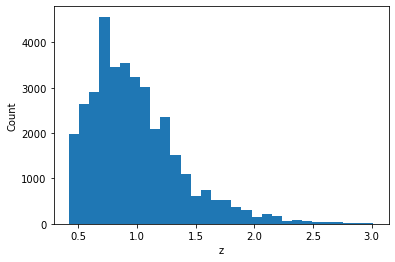

In [12]:
# Quick check of the redshift distribution of the galaxies in the catalog

print(f'Number of galaxies in the catalog: Ngal = {len(cl.galcat)}')
tmp = plt.hist(cl.galcat['z'], bins=30)
plt.xlabel('z')
plt.ylabel('Count')

### 2. Use CLMM to compute the reduced tangential shear profile

#### Compute the tangential and cross shear profiles

In [20]:
bin_edges = clmm.polaraveraging.make_bins(0.15, 10, 15, method='evenlog10width') # in Mpc
cl.compute_shear(geometry="flat")
cl.make_shear_profile("radians", "Mpc", bins=bin_edges,cosmo=cosmo)

radius_min,radius,radius_max,gt,gt_err,gx,gx_err,z,z_err,n_src
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
0.15,0.17636942351321439,0.19846556968648293,0.02037417866393367,0.0035284277510696086,0.006753624804594845,0.003687532406500275,0.971778890840735,0.05041615834029067,34
0.19846556968648293,0.23218089353404303,0.26259054900653483,0.02679741876302726,0.0027189139082722186,0.0007119377886252487,0.0023036485227813878,1.020568689467205,0.058193913495320986,53
0.26259054900653483,0.3059704420440446,0.3474345526857884,0.041066700638701485,0.0019084106346784952,0.0016804474260400152,0.0014455222242051205,1.0265077465792039,0.04849007345410995,82
0.3474345526857884,0.4072589534929289,0.45969197618368907,0.04650956621608166,0.0011971729597659692,0.0009971665591332357,0.0007991042517062868,1.0393406936116252,0.03719695065774041,130
0.45969197618368907,0.5396605648750517,0.60822019955734,0.049171216690907904,0.0006989442328396026,0.00015119088451375306,0.0003589668969936726,0.9758493108139988,0.023369400483367962,261
0.60822019955734,0.7076302276523957,0.8047384559998256,0.03782777299821912,0.0004936163860593951,0.00022641596737203016,0.00037354499832125955,0.9192423022575893,0.01632509783150775,464
0.8047384559998256,0.9424747432620386,1.0647525074575073,0.02515375248528569,0.0003594902655390658,-0.00017164485861469967,0.0003212987611452593,0.9769176552238986,0.014443458340591367,730
1.0647525074575073,1.2470483876853413,1.4087780864511024,0.02463116395646268,0.0002893234018049065,0.0006363728882482774,0.00028139378807150476,0.9826323955808695,0.010498800725560982,1194
1.4087780864511024,1.6514264711112452,1.8639596365956759,0.014253470998703497,0.00028271094659568864,0.0008274010881759553,0.0003006187514405246,0.9901527835609454,0.008637894700042961,2076


### 3. Sanity check: use CLMM to compute the corresponding NFW model, given the mass the halo

- The mass definition used in cosmoDC2 is the friend-of-friend mass with linking length b=0.168. In CLMM, the default mass definition is $M_{200,m}$: it uses an overdensity parameter $\Delta=200$ with respect to the matter density. Here, we are directly using $M_{\rm fof}$ in the modeling functions of CLMM, which is inconsistent. However, the goal here is to check that model and data are roughly in agreement. 
- The model should take into account the redshift distribution of the background galaxies. Here, we simply use the average redshift of the galaxy catalog as this is a quick sanity check that things behave as expected. 

In [26]:
reduced_shear = clmm.predict_reduced_tangential_shear(cl.profile['radius']*cosmo.h, mass_cl*cosmo.h, 4.,z_cl, cl.profile['z'], cosmo,
                                                      delta_mdef=200,halo_profile_model='nfw')  

Text(0, 0.5, '<shear>')

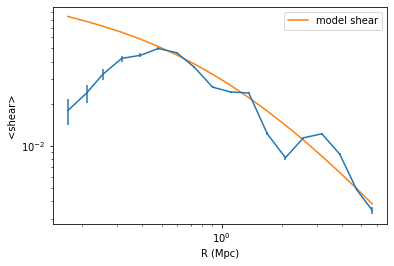

In [27]:
plt.errorbar(profile['radius'],profile['gt'],yerr=profile['gt_err'])
plt.plot(profile['radius'],reduced_shear_model, label='model shear')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('R (Mpc)')
plt.ylabel('<shear>')

Data and model are in rough agreement at large radii. In the inner region, the lack of resolution of the DC2 simulations yield an unphysical attenuation of the signal. This was remarked upon in the cosmoDC2 paper (https://arxiv.org/abs/1907.06530).